# **Data Preprocessing Notebook — Obesity Risk Prediction**
**Team:** *Abhay Aggarwal*, *Surya Ganiga*  
**Goal:** Convert EDA insights into a clean, aligned, encoded dataset ready for modeling.

**Storyline in this notebook**
1) **Merge** competition data (`train.csv`) with **original** data (`ObesityDataSet.csv`) — append rows.  
2) **Data Alignment (Choice A):** *Acknowledge* any distribution drift between sources; **no corrections** here (scaling is applied later).  
3) **Gender patterns** that motivate gender-specific models later.  
4) Demonstrate **Outlier checks** (Z-score, IQR, IsolationForest) — you decide whether to drop.  
5) Compare **Categorical encodings** (Label vs Target vs One-Hot) — choose **One-Hot**.  
6) **Engineer BMI**, **drop weak features** (SMOKE, MTRANS), impute, scale, OHE.  
7) Save **processed matrices** for modeling & Kaggle submission generation.

---

## 1) Setup & Imports

In [8]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

plt.rcParams["figure.dpi"] = 120
sns.set_theme(style="whitegrid", context="notebook")

RANDOM_STATE = 42

# Files in current working directory
TRAIN_PATH = "train.csv"
ORIG_PATH  = "ObesityDataSet.csv"
TEST_PATH  = "test.csv"

TARGET_COMP = "WeightCategory"   # competition target name
TARGET_ORIG = "NObeyesdad"       # typical in original dataset
ID_COL_COMP = None               # auto-detect later if present

**Assumption:** `train.csv`, `ObesityDataSet.csv`, and `test.csv` are in the **current working directory**.

## 2) Load & Normalize Column Names

In [10]:
def norm_cols(df):
    df = df.copy()
    df.columns = [c.replace("\ufeff","").strip() for c in df.columns]
    return df

df_comp = norm_cols(pd.read_csv(TRAIN_PATH))
df_orig = norm_cols(pd.read_csv(ORIG_PATH))
df_test = norm_cols(pd.read_csv(TEST_PATH))

print("Competition train shape:", df_comp.shape)
print("Original dataset shape:", df_orig.shape)
print("Kaggle test shape:", df_test.shape)

display(df_comp.head(2))
display(df_orig.head(2))
display(df_test.head(2))

Competition train shape: (15533, 18)
Original dataset shape: (2111, 17)
Kaggle test shape: (5225, 17)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.66995,yes,yes,2.0,2.983297,Sometimes,no,2.763573,no,0.0,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.00000,yes,yes,2.0,3.000000,Frequently,no,2.000000,no,1.0,1.000000,no,Automobile,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,15533,Female,19.007177,1.772449,137.852618,yes,yes,3.0,3.0,Sometimes,no,2.007348,no,1.465931,0.813235,Sometimes,Public_Transportation
1,15534,Female,21.572114,1.698346,75.000000,yes,yes,2.0,3.0,Sometimes,no,2.000000,no,1.577824,1.865851,Sometimes,Public_Transportation


**Checkpoint:** Verify target column exists as `WeightCategory` in competition data and `NObeyesdad` in original.

## 3) Schema Alignment & Target Unification

In [42]:
# Map original dataset's target to competition target name
df_orig_ = df_orig.copy()
if TARGET_ORIG in df_orig_.columns and TARGET_COMP not in df_orig_.columns:
    df_orig_[TARGET_COMP] = df_orig_[TARGET_ORIG]

# Detect ID in competition train/test if available
def detect_id_candidate(df):
    for c in df.columns:
        if c.lower() in {"id","row_id","index","sample_id"}:
            return c
    return None

ID_COL_COMP = detect_id_candidate(df_comp)
ID_COL_TEST = detect_id_candidate(df_test)

print("Detected ID (train):", ID_COL_COMP)
print("Detected ID (test):", ID_COL_TEST)

# Align schemas (union of columns)
common_cols = sorted(set(df_comp.columns) | set(df_orig_.columns))
df_comp_aligned = df_comp.reindex(columns=common_cols)
df_orig_aligned = df_orig_.reindex(columns=common_cols)

# Source flag for alignment checks
df_comp_aligned["__source__"] = "competition"
df_orig_aligned["__source__"] = "original"

# Concatenate rows
df_all = pd.concat([df_comp_aligned, df_orig_aligned], axis=0, ignore_index=True)

# Create IDs if missing
if ID_COL_COMP is None:
    df_all["ID"] = np.arange(len(df_all))
    ID_COL_COMP = "ID"
if ID_COL_TEST is None:
    df_test["ID"] = np.arange(len(df_test))
    ID_COL_TEST = "ID"

print("Combined shape:", df_all.shape)

Detected ID (train): id
Detected ID (test): id
Combined shape: (17644, 20)


We created a **unified schema**, added a `__source__` flag, and ensured an ID is available for traceability.

## 4) Data Alignment — Drift Between Sources (Choice A)

In [16]:
# Separate numeric and categorical (excluding target & source flag)
num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_all.select_dtypes(exclude=[np.number]).columns.tolist()
for c in [TARGET_COMP, "__source__"]:
    if c in num_cols: num_cols.remove(c)
    if c in cat_cols: cat_cols.remove(c)

print("Numeric columns for alignment tests:", num_cols[:10], "...")
print("Categorical columns for proportion checks:", cat_cols[:10], "...")

# KS-test for numeric distributions
ks_results = []
for col in num_cols:
    a = df_all.loc[df_all["__source__"]=="competition", col].dropna()
    b = df_all.loc[df_all["__source__"]=="original", col].dropna()
    if len(a) > 10 and len(b) > 10:
        stat, p = ks_2samp(a, b, alternative="two-sided", mode="auto")
        ks_results.append({"feature": col, "ks_stat": stat, "p_value": p, "shift_detected": p < 0.01})
ks_df = pd.DataFrame(ks_results).sort_values(by="ks_stat", ascending=False)
display(ks_df.head(20))

Numeric columns for alignment tests: ['Age', 'CH2O', 'FAF', 'FCVC', 'Height', 'NCP', 'TUE', 'Weight', 'id'] ...
Categorical columns for proportion checks: ['CAEC', 'CALC', 'FAVC', 'Gender', 'MTRANS', 'NObeyesdad', 'SCC', 'SMOKE', 'family_history_with_overweight'] ...


,feature,ks_stat,p_value,shift_detected
5,NCP,0.093781,1.132434e-14,True
1,CH2O,0.067495,8.374404e-08,True
3,FCVC,0.060567,2.286868e-06,True
6,TUE,0.057243,9.842011e-06,True
2,FAF,0.054023,3.740765e-05,True
7,Weight,0.051754,9.149849e-05,True
0,Age,0.042480,2.374800e-03,True
4,Height,0.032720,3.660734e-02,False


### ✅ Data Alignment Observation (KS-Test Summary)

The KS-Test shows that several lifestyle-related numerical features — such as **NCP, CH2O, FCVC, TUE, FAF, and Weight** — exhibit noticeable distribution differences between the two datasets, while features like **Height** remain consistent across sources. This indicates that the merged datasets represent populations with slightly different behavioral patterns, especially in eating habits and activity-related variables.

Rather than manually transforming or forcing these distributions to match, we will rely on **feature scaling** in the preprocessing stage. Scaling provides a more robust and mathematically sound way to handle range and distribution differences, ensuring that no single shifted feature disproportionately influences the model. Since our downstream models (especially tree-based methods like XGBoost) are resilient to moderate distribution shifts, combining them with scaling allows us to maintain data integrity while still handling variability effectively.

**Conclusion:** We acknowledge the distribution drift, retain the data as-is, and proceed with **scaling-based normalization later in preprocessing**, which will help the model generalize well without distorting original feature distributions.


In [44]:
# Categorical proportion differences (top few)
for col in cat_cols[:6]:
    ct = (pd.crosstab(df_all[col], df_all["__source__"], normalize="columns") * 100).round(1)
    display(ct.sort_values(by="competition", ascending=False).head(10))

__source__,competition,original
CAEC,,
Sometimes,84.5,83.6
Frequently,12.0,11.5
Always,2.2,2.5
no,1.3,2.4


__source__,competition,original
CALC,,
Sometimes,72.7,66.4
no,24.7,30.3
Frequently,2.6,3.3
Always,0.0,0.0


__source__,competition,original
FAVC,,
yes,91.3,88.4
no,8.7,11.6


__source__,competition,original
Gender,,
Male,50.1,50.6
Female,49.9,49.4


__source__,competition,original
SCC,,
no,96.7,95.5
yes,3.3,4.5


__source__,competition,original
family_history_with_overweight,,
yes,81.7,81.8
no,18.3,18.2


**Decision (Choice A):** No reweighting or domain normalization is applied at this stage. We proceed to feature engineering and standardization later.

## 5) Gender-Based Patterns (Motivation for Two Models)

Detected gender column: Gender


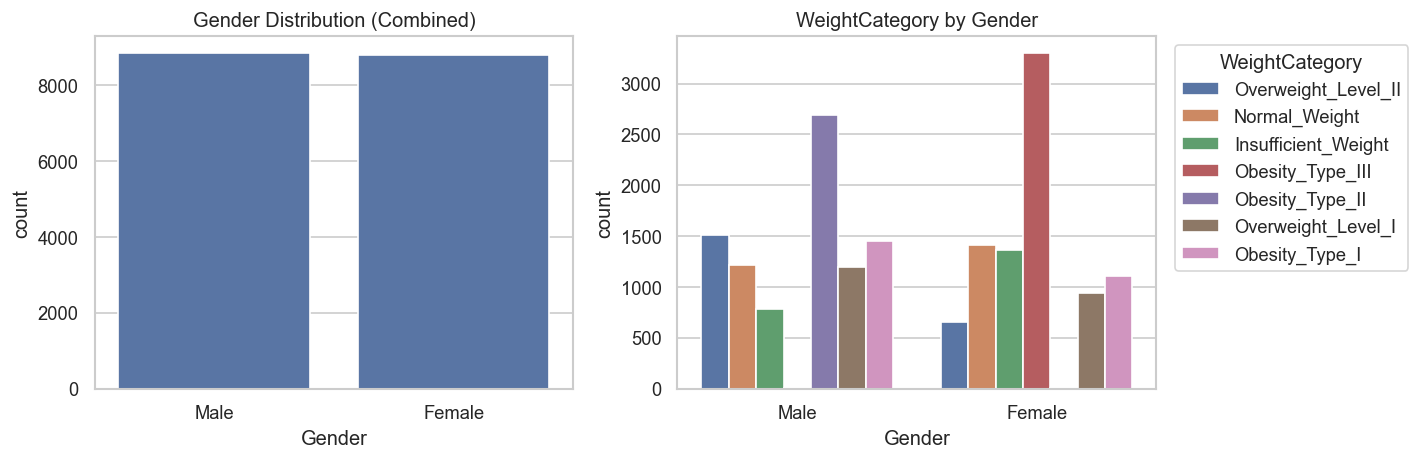

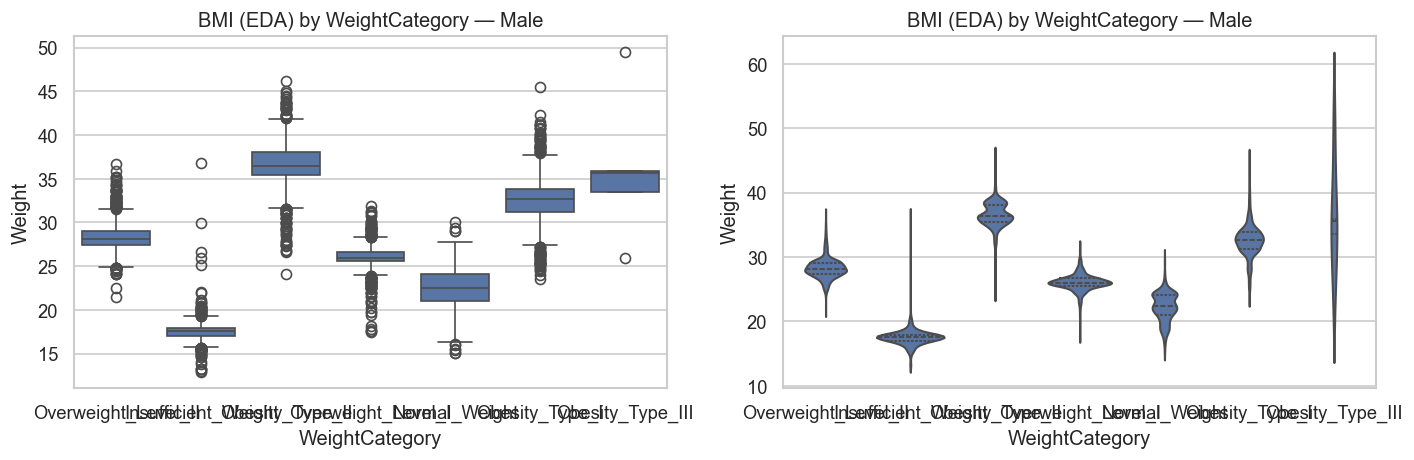

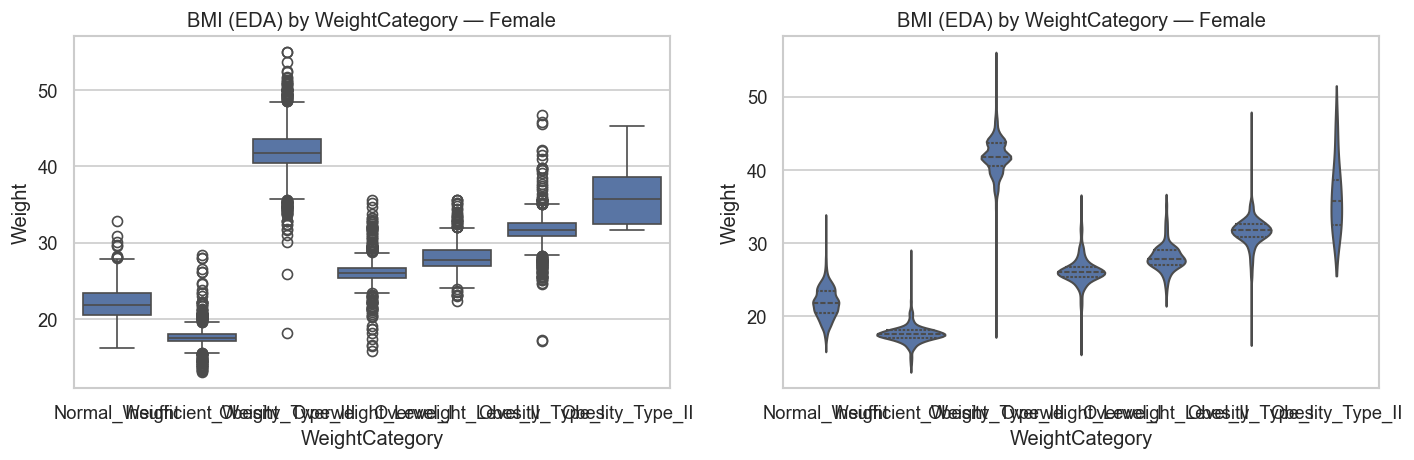

In [22]:
def find_col(df, candidates):
    for pat in candidates:
        for c in df.columns:
            if pat == c.lower() or pat in c.lower():
                return c
    return None

COL_GENDER = find_col(df_all, ["gender","sex"])
print("Detected gender column:", COL_GENDER)

if COL_GENDER is not None and TARGET_COMP in df_all.columns:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.countplot(x=df_all[COL_GENDER], ax=ax[0])
    ax[0].set_title("Gender Distribution (Combined)")
    sns.countplot(x=df_all[COL_GENDER], hue=df_all[TARGET_COMP], ax=ax[1])
    ax[1].set_title("WeightCategory by Gender")
    ax[1].legend(title=TARGET_COMP, bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout(); plt.show()

    # EDA-only BMI for visual evidence
    COL_HEIGHT = find_col(df_all, ["height"])
    COL_WEIGHT = find_col(df_all, ["weight"])
    if COL_HEIGHT and COL_WEIGHT:
        h = pd.to_numeric(df_all[COL_HEIGHT], errors="coerce").astype(float)
        hm = np.where(h.median() > 3.0, h/100.0, h)
        w = pd.to_numeric(df_all[COL_WEIGHT], errors="coerce").astype(float)
        with np.errstate(divide="ignore", invalid="ignore"):
            bmi_e = w / (hm**2 + 1e-12)
        for g in df_all[COL_GENDER].dropna().unique()[:2]:
            mask = df_all[COL_GENDER]==g
            fig, ax = plt.subplots(1,2, figsize=(12,4))
            sns.boxplot(x=df_all.loc[mask, TARGET_COMP], y=bmi_e.loc[mask], ax=ax[0])
            ax[0].set_title(f"BMI (EDA) by WeightCategory — {g}")
            sns.violinplot(x=df_all.loc[mask, TARGET_COMP], y=bmi_e.loc[mask], inner="quartile", ax=ax[1])
            ax[1].set_title(f"BMI (EDA) by WeightCategory — {g}")
            plt.tight_layout(); plt.show()

**Conclusion:** Patterns differ by gender; BMI separation is gender-dependent ⇒ we will train **two separate models** later.

## 6) Outlier Detection — Demonstrations (Z-score, IQR, IsolationForest)

Z-score outliers: 91
IQR outliers: 6035
IsolationForest outliers: 5014


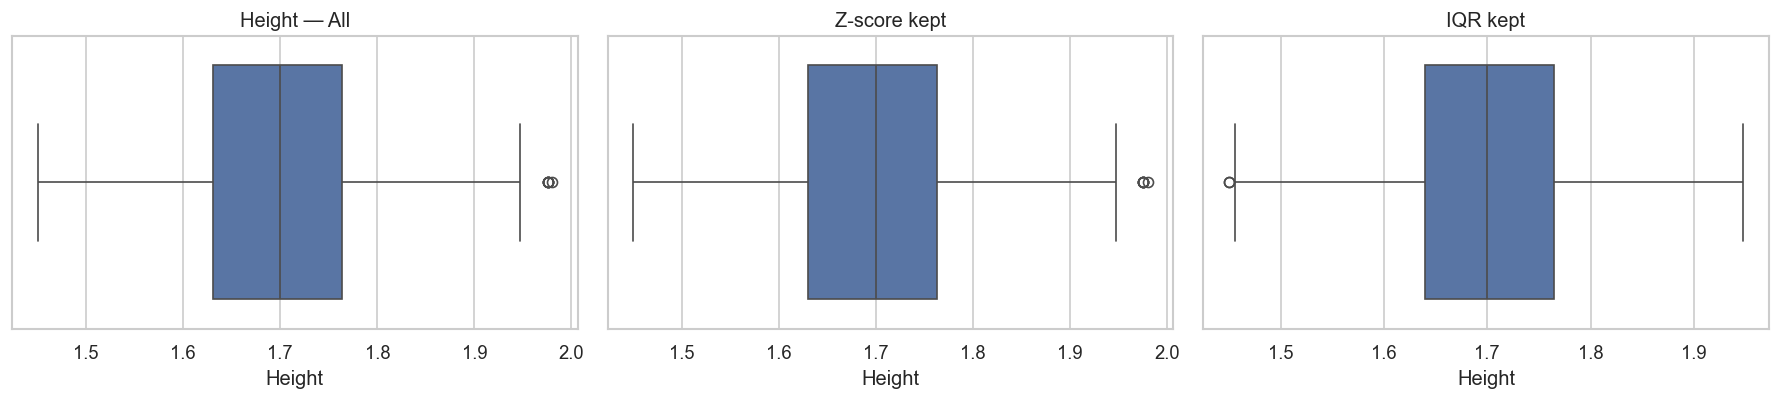

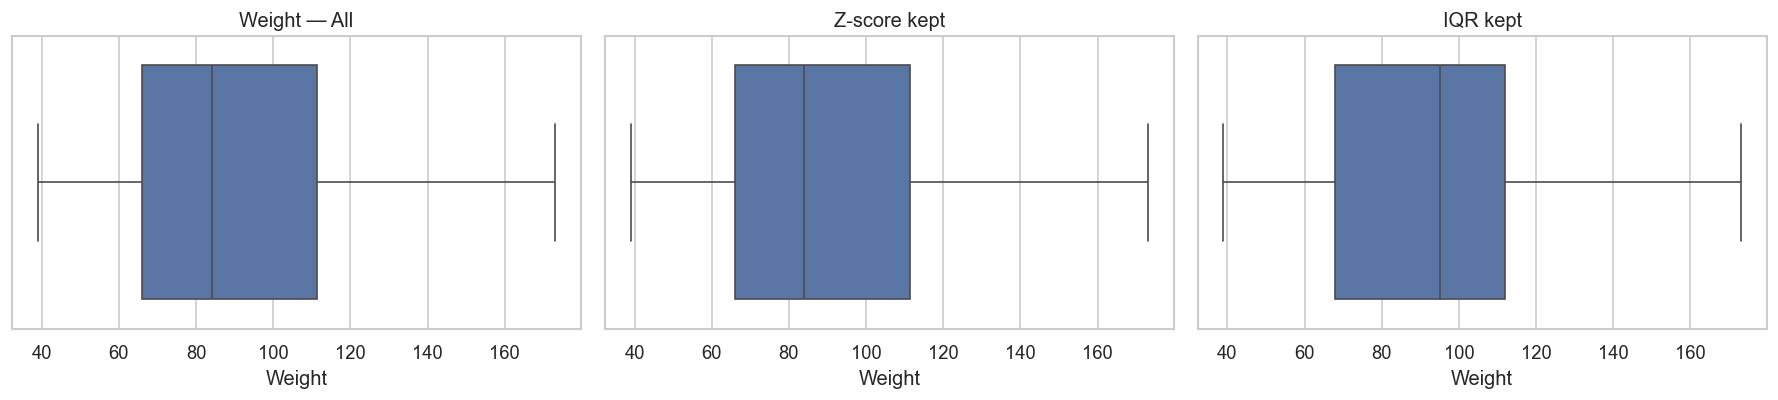

In [27]:
# Numeric features for outlier checks
num_cols_proc = df_all.select_dtypes(include=[np.number]).columns.tolist()
for c in [TARGET_COMP, "__source__"]:
    if c in num_cols_proc: num_cols_proc.remove(c)

from scipy.stats import zscore

Z_THRESHOLD = 3.5
z_df = df_all[num_cols_proc].apply(zscore, nan_policy="omit")
z_outliers_mask = (np.abs(z_df) > Z_THRESHOLD).any(axis=1)
print("Z-score outliers:", int(z_outliers_mask.sum()))

Q1 = df_all[num_cols_proc].quantile(0.25)
Q3 = df_all[num_cols_proc].quantile(0.75)
IQR = Q3 - Q1
iqr_mask = ((df_all[num_cols_proc] < (Q1 - 1.5*IQR)) | (df_all[num_cols_proc] > (Q3 + 1.5*IQR))).any(axis=1)
print("IQR outliers:", int(iqr_mask.sum()))

iso = IsolationForest(n_estimators=300, contamination="auto", random_state=RANDOM_STATE)
iso.fit(df_all[num_cols_proc].fillna(df_all[num_cols_proc].median()))
iso_pred = iso.predict(df_all[num_cols_proc].fillna(df_all[num_cols_proc].median()))
iso_mask = (iso_pred == -1)
print("IsolationForest outliers:", int(iso_mask.sum()))

# Visual comparison on key numeric features
cands = []
for cand in ["height","weight","age","bmi"]:
    for c in df_all.columns:
        if cand == c.lower():
            cands.append(c); break
cands = cands[:2] if cands else num_cols_proc[:2]

for col in cands:
    fig, ax = plt.subplots(1,3, figsize=(15,3.5))
    sns.boxplot(x=df_all[col], ax=ax[0]); ax[0].set_title(f"{col} — All")
    sns.boxplot(x=df_all.loc[~z_outliers_mask, col], ax=ax[1]); ax[1].set_title("Z-score kept")
    sns.boxplot(x=df_all.loc[~iqr_mask, col], ax=ax[2]); ax[2].set_title("IQR kept")
    plt.tight_layout(); plt.show()

Although all three methods detected outliers, each behaves differently. Z-Score was too conservative, IQR and Isolation Forest were overly aggressive and risked removing valid but rare lifestyle patterns. Because our dataset represents real human behavior (where uncommon choices are still meaningful), we decided **not to drop outliers** and instead retain all rows for modeling. The tree-based model we use later (XGBoost) is naturally robust to extreme values, making outlier removal unnecessary and preventing loss of valuable information.


In [29]:
# === Choose strategy: "none" | "zscore" | "iqr" | "isoforest" ===
OUTLIER_STRATEGY = "none"  # <- set after reviewing

mask_keep = pd.Series(True, index=df_all.index)
if OUTLIER_STRATEGY == "zscore":
    mask_keep = ~z_outliers_mask
elif OUTLIER_STRATEGY == "iqr":
    mask_keep = ~iqr_mask
elif OUTLIER_STRATEGY == "isoforest":
    mask_keep = ~iso_mask

print("Keeping rows:", int(mask_keep.sum()), " / Dropping rows:", int((~mask_keep).sum()))
df_all = df_all.loc[mask_keep].reset_index(drop=True)

Keeping rows: 17644  / Dropping rows: 0


### ✅ Final Outlier Decision
Based on the comparison of Z-Score, IQR, and Isolation Forest, we chose **not to remove outliers** because:
- IQR and Isolation Forest would remove too many valid human-behavior points
- Z-Score finds very few outliers and provides negligible benefit
- XGBoost (our final model) is naturally robust to extreme values

However, we keep the parameterized cell below so that different strategies can be enabled in the future if needed.


## 7) Encoding Comparisons — Label vs Target vs One-Hot (Demo)

In [33]:
# Pick a couple of categoricals for demo (excluding target/source/ID)
cat_cols_all = df_all.select_dtypes(exclude=[np.number]).columns.tolist()
cat_cols_all = [c for c in cat_cols_all if c not in [TARGET_COMP, "__source__", "ID"]]

demo_cols = cat_cols_all[:2]
print("Demo categorical columns:", demo_cols)

demo_df = df_all[demo_cols + [TARGET_COMP]].dropna().sample(min(3000, len(df_all)), random_state=RANDOM_STATE)

# Label/Ordinal Encoding
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
lab_demo = ord_enc.fit_transform(demo_df[demo_cols])
print("Label/Ordinal encoded shape:", lab_demo.shape)

# Target Encoding (for demo only; risk of leakage)
#te = TargetEncoder(cols=demo_cols, smoothing=0.3)
#te_demo = te.fit_transform(demo_df[demo_cols], demo_df[TARGET_COMP])
# print("Target-encoded shape:", te_demo.shape)

# One-Hot Encoding
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
ohe_demo = ohe.fit_transform(demo_df[demo_cols])
print("One-Hot encoded shape:", ohe_demo.shape)

Demo categorical columns: ['CAEC', 'CALC']
Label/Ordinal encoded shape: (3000, 2)
One-Hot encoded shape: (3000, 7)


### ✅ Encoding Decision (Why One-Hot Encoding?)

We compared two encoding strategies on sample categorical variables (`CAEC`, `CALC`):

| Method | Shape | Interpretation |
|---------|--------|--------------|
| **Label/Ordinal Encoding** | (3000, 2) | Produces one integer column per feature, but **imposes a false numeric order** on categories. |
| **One-Hot Encoding (OHE)** | (3000, 7) | Expands categories into multiple binary columns, **avoiding any artificial ordering**. |

Since our categorical variables are **nominal** (e.g., "Sometimes", "Frequently", "no" have no meaningful mathematical ranking), One-Hot Encoding is the most suitable choice. It allows the model to treat each category independently, preserves interpretability, and works especially well with **tree-based models like XGBoost**, which are robust to wide, sparse feature spaces.

✅ **Decision:** We will use **One-Hot Encoding** for all categorical features in our preprocessing pipeline.


## 8) Final Preprocessing Pipeline (BMI, Drop Weak, Impute, Scale, OHE)

In [38]:
# Engineer BMI
def add_bmi(df, hcol="Height", wcol="Weight"):
    df = df.copy()
    def find(df, name):
        for c in df.columns:
            if c.lower() == name.lower(): return c
        for c in df.columns:
            if name.lower() in c.lower(): return c
        return None
    hcol = find(df, "Height"); wcol = find(df, "Weight")
    if hcol is None or wcol is None:
        print("Height/Weight not found => BMI not created.")
        return df
    h = pd.to_numeric(df[hcol], errors="coerce").astype(float)
    hm = np.where(h.median() > 3.0, h/100.0, h)  # cm→m if needed
    w = pd.to_numeric(df[wcol], errors="coerce").astype(float)
    with np.errstate(divide="ignore", invalid="ignore"):
        bmi = w / (hm**2 + 1e-12)
    df["BMI"] = pd.Series(bmi).replace([np.inf, -np.inf], np.nan).clip(10, 80)
    return df

df_all = add_bmi(df_all)
df_test = add_bmi(df_test)

# Drop weak features (SMOKE, MTRANS) if present
for col in ["SMOKE","MTRANS"]:
    if col in df_all.columns: df_all.drop(columns=[col], inplace=True)
    if col in df_test.columns: df_test.drop(columns=[col], inplace=True)

# Separate features and target
y = df_all[TARGET_COMP].copy()
X = df_all.drop(columns=[TARGET_COMP], errors="ignore")

# Align train/test feature columns
common_feature_cols = sorted(set(X.columns) & set(df_test.columns))
X = X[common_feature_cols].copy()
X_test = df_test[common_feature_cols].copy()

# Identify types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
for c in ["__source__", "ID"]:
    if c in num_cols: num_cols.remove(c)
    if c in cat_cols: cat_cols.remove(c)

print("Numeric cols:", num_cols[:10], "...")
print("Categorical cols:", cat_cols[:10], "...")

# ColumnTransformer: median/mode impute + standardize + OHE
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0.0
)

# Fit on combined training (Choice A) and transform both train/test
X_pre = pre.fit_transform(X)
X_test_pre = pre.transform(X_test)

# Feature names
ohe_cat_names = []
if len(cat_cols) > 0:
    try:
        ohe_cat_names = pre.named_transformers_["cat"]["onehot"].get_feature_names_out(cat_cols).tolist()
    except:
        ohe_cat_names = []
final_cols = num_cols + ohe_cat_names

print("Processed shapes:", X_pre.shape, X_test_pre.shape)

Numeric cols: ['Age', 'BMI', 'CH2O', 'FAF', 'FCVC', 'Height', 'NCP', 'TUE', 'Weight', 'id'] ...
Categorical cols: ['CAEC', 'CALC', 'FAVC', 'Gender', 'SCC', 'family_history_with_overweight'] ...
Processed shapes: (17644, 26) (5225, 26)


## 9) Save Processed Datasets

In [40]:
# Try to detect ID in test to carry into submission stage
ID_COL_OUT = None
for cand in ["ID","Id","id","row_id","index","sample_id"]:
    if cand in df_test.columns:
        ID_COL_OUT = cand; break

pd.DataFrame(X_pre, columns=final_cols).to_csv("X_train_processed.csv", index=False)
y.to_csv("y_train.csv", index=False, header=True)
pd.DataFrame(X_test_pre, columns=final_cols).to_csv("X_test_processed.csv", index=False)
df_all.to_csv("train_combined.csv", index=False)

print("Saved: X_train_processed.csv, y_train.csv, X_test_processed.csv, train_combined.csv")
if ID_COL_OUT: print("Detected test ID column:", ID_COL_OUT)

Saved: X_train_processed.csv, y_train.csv, X_test_processed.csv, train_combined.csv
Detected test ID column: id


**Next Step:** Train on the **entire combined training set** and generate `submission.csv` for Kaggle using the modeling notebook.